## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# %pip install moviepy

In [ ]:
# %pip install tensorflow_hub

In [ ]:
import librosa
import glob
import librosa.display
import matplotlib.pyplot as plt
from moviepy.editor import *
import io
# import tensorflow
# import concurrent.futures
# import tensorflow as tf
# import tensorflow_io as tfio
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# import tensorflow_hub as hub
# from tensorflow.keras import layers, models
# import torch
# print(torch.__version__)
# import torch.nn.functional as F
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from functools import partial
from datetime import datetime
from datetime import timedelta
import shutil

In [ ]:
pwd

'/content'

In [ ]:
cd '/content/drive/MyDrive/Capstone/train_segments'

/content/drive/MyDrive/Capstone/train_segments


In [ ]:
directory = "/content/drive/MyDrive/Capstone/train_segments"

# Function to convert string time to timedelta
def convert_to_timedelta(time_str):
    parts = time_str.split(':')
    minutes = int(parts[0])
    seconds = int(parts[1]) if len(parts) > 1 else 0
    return timedelta(minutes=minutes, seconds=seconds)

# Function to generate intervals from Excel file
def gen_excel_data(file):
    df = pd.read_excel(file, usecols=[0, 1, 2], engine='openpyxl')
    df_clean = df.dropna()
    data_as_list = df_clean.values.tolist()

    new_intervals = []

    for row in data_as_list:
        current_time = convert_to_timedelta(row[0])
        end_time = convert_to_timedelta(row[1])
        classification = row[2]
        while current_time < end_time:
            next_time = min(current_time + pd.Timedelta(seconds=3), end_time)
            new_intervals.append([current_time, next_time, classification])
            current_time = next_time

    return new_intervals

In [ ]:
import pandas as pd
from datetime import timedelta

def process_data(excel_file_path, mp3_file_path, save_path_csv):
    # Load metadata from the Excel file
    metadata = pd.read_excel(excel_file_path, engine='openpyxl')

    # Load the entire audio file
    audio, sr = librosa.load(mp3_file_path, sr=16000)
    audio_duration = librosa.get_duration(y=audio, sr=sr)

    # Iterate over each interval in the metadata
    for i, row in metadata.iterrows():
        start_time_str = row['Start']
        end_time_str = row['Stop']
        classification = row['Code']  # Retrieve classification from the 'code' column

        # Convert start and end times to timedelta objects
        start_time = timedelta(minutes=int(start_time_str.split(':')[0]), seconds=int(start_time_str.split(':')[1]))
        end_time = timedelta(minutes=int(end_time_str.split(':')[0]), seconds=int(end_time_str.split(':')[1]))

        # Check if end time exceeds audio duration, adjust if necessary
        if end_time.total_seconds() > audio_duration:
            end_time = timedelta(seconds=audio_duration)

        # Convert start and end times to samples
        start_sample = int(start_time.total_seconds() * sr)
        end_sample = int(end_time.total_seconds() * sr)

        # Extract the interval
        audio_interval = audio[start_sample:end_sample]

        # Compute the spectrogram
        D = librosa.stft(audio_interval)
        D_magnitude = np.abs(D)
        D_db = librosa.amplitude_to_db(D_magnitude, ref=np.max)

        # Save the spectrogram to a CSV file
        spectrogram_csv_file = f"{os.path.splitext(os.path.basename(mp3_file_path))[0]}_segment_{i}_{classification}.csv"
        spectrogram_csv_path = os.path.join(save_path_csv, spectrogram_csv_file)
        np.savetxt(spectrogram_csv_path, D_db, delimiter=',')

        # Print processing message
        print(f"Processed segment {i}: {start_time_str} to {end_time_str}, classification: {classification}, saved as {spectrogram_csv_file}")

path_to_excel_files = "/content/drive/My Drive/Capstone/train_segments/"
path_to_mp3_files = "/content/drive/MyDrive/Capstone/train_segments"

In [ ]:
ls

'301 T1 part 2 child audio.mp3'   '554 T1 part 2 child audio.mp3'    metadata.csv   segments/
'301 T1 part 2 child audio.xlsx'  '554 T1 part 2 child audio.xlsx'   my_model.h5


In [ ]:
# Generate intervals from Excel files
excel_files = glob.glob(path_to_excel_files + "*.xlsx")
for excel_file in excel_files:
    intervals = gen_excel_data(excel_file)
    mp3_file_name = os.path.splitext(os.path.basename(excel_file))[0] + ".mp3"
    mp3_file_path = os.path.join(path_to_mp3_files, mp3_file_name)
    save_path_csv = "/content/drive/MyDrive/Capstone/train_segments/segments"
    process_data(excel_file, mp3_file_path, save_path_csv)

AttributeError: 'datetime.time' object has no attribute 'split'

## Training Model

In [ ]:
seg_dir = "/content/drive/MyDrive/Capstone/train_segments/segments"

In [ ]:
import os
import random


def select_files(directory, num_files_a, num_files_i, num_files_b):
    selected_files = []
    files_by_class = {}
    limit = 0
    # Iterate over files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            classification = filename.split('_')[-1].split('.')[0]
            files_by_class.setdefault(classification, []).append(filename)

    # Select files for each classification
    for classification, files in files_by_class.items():
        if classification == 'a':
            limit = num_files_a
        elif classification == 'i':
            limit = num_files_i
        elif classification == 'b':
            limit = num_files_b
        # elif classification == 'o':
        #     limit = num_files_o

        # Extend only up to the limit of files for each class
        selected_files.extend(files[:limit])

    return selected_files

In [ ]:
from sklearn.preprocessing import StandardScaler

def load_and_normalize_files(selected_files, directory):
    # Initialize lists to store features and labels
    features = []
    labels = []

    # Iterate over selected files
    for filename in selected_files:
        # Load CSV file
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)

        # Extract features (assuming the CSV contains feature columns)
        # Modify this part according to your feature extraction method
        extracted_features = df.values

        # Normalize features using StandardScaler
        scaler = StandardScaler()
        normalized_features = scaler.fit_transform(extracted_features)

        # Store normalized features and label
        features.append(normalized_features)
        labels.append(filename.split('_')[-1].split('.')[0])  # Extract classification from filename

    return np.array(features), labels

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_and_normalize_files(selected_files, directory, max_length=1000):
    features = []
    labels = []
    class_mapping = {'a': 0, 'i': 1, 'b': 2}

    scaler = StandardScaler()  # Initialize scaler to be used for all files for consistency

    for filename in selected_files:
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        extracted_features = df.values

        # Normalize features
        normalized_features = scaler.fit_transform(extracted_features)

        # Pad or truncate rows (sequences) to max_length
        if normalized_features.shape[0] < max_length:
            # Pad rows if fewer than max_length
            padded_features = np.pad(normalized_features, ((0, max_length - normalized_features.shape[0]), (0, 0)), 'constant', constant_values=0)
        else:
            # Truncate rows if more than max_length
            padded_features = normalized_features[:max_length, :]

        # Pad or truncate columns (features per sequence) to max_length
        if padded_features.shape[1] < max_length:
            # Pad columns if fewer than max_length
            padded_features = np.pad(padded_features, ((0, 0), (0, max_length - padded_features.shape[1])), 'constant', constant_values=0)
        elif padded_features.shape[1] > max_length:
            # Truncate columns if more than max_length
            padded_features = padded_features[:, :max_length]

        features.append(padded_features)
        label = filename.split('_')[-1].split('.')[0]
        encoded_label = class_mapping[label]
        labels.append(encoded_label)

        # Debug: print the shape of each processed file
        #print(f"Processed file {filename} with shape {padded_features.shape}")

    # Stack features ensuring they are the same shape
    features_array = np.stack(features)  # Use np.stack to ensure all feature arrays are stacked properly
    labels_array = np.array(labels)

    return features_array, labels_array

In [ ]:
# Example usage
directory = "/content/drive/MyDrive/Capstone/train_segments/segments"
max_length = 1000  # This needs to be the maximum sequence length expected
num_files_a = 120
num_files_i = 120
num_files_b = 120
# num_files_o = 100

selected_files = select_files(directory, num_files_a, num_files_i, num_files_b)

# Load and normalize files with padding
features, labels = load_and_normalize_files(selected_files, directory, max_length=max_length)

# Check shapes and print results
print(features.shape)
print(labels)

(360, 1000, 1000)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (adjust test_size as needed)
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Print the shapes of the training and validation sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (288, 1000, 1000)
Validation set shape: (72, 1000, 1000)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD

# Define the input shape
input_shape = (1000, 1000)  # Shape of each spectrogram

# Define the number of classes
num_classes = 4  # Number of classes (adult, infant, background, overlap)

In [ ]:
from keras.layers import Dense
from keras.regularizers import l2
# Define the LSTM model
model = Sequential([
    LSTM(units=128, input_shape=input_shape, return_sequences=True),
    BatchNormalization(),  # Add BatchNormalization layer
    Dropout(0.3),  # Add dropout for regularization
    LSTM(units=128),
    BatchNormalization(),  # Add BatchNormalization layer
    Dropout(0.5),  # Add dropout for regularization
    Dense(64, activation='relu'),  # Add a dense layer
    Dropout(0.3),  # Add dropout for regularization
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))  # Output layer with softmax activation
])
learning_rate = 0.001
epochs = 100
wd = learning_rate/epochs

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.0001,momentum=.99, weight_decay= wd),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1000, 128)         578048    
                                                                 
 batch_normalization_4 (Bat  (None, 1000, 128)         512       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 1000, 128)         0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 batch_normalization_5 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 128)              

In [ ]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=64, callbacks=[early_stopping])


Epoch 1/100
5/5 [==============================] - 6s 578ms/step - loss: 2.0341 - accuracy: 0.2326 - val_loss: 1.3372 - val_accuracy: 0.6250
Epoch 2/100
5/5 [==============================] - 1s 251ms/step - loss: 1.8172 - accuracy: 0.3507 - val_loss: 1.3208 - val_accuracy: 0.5556
Epoch 3/100
5/5 [==============================] - 1s 250ms/step - loss: 1.7842 - accuracy: 0.3264 - val_loss: 1.3009 - val_accuracy: 0.6111
Epoch 4/100
5/5 [==============================] - 1s 250ms/step - loss: 1.6433 - accuracy: 0.3785 - val_loss: 1.2793 - val_accuracy: 0.5972
Epoch 5/100
5/5 [==============================] - 1s 248ms/step - loss: 1.4143 - accuracy: 0.4583 - val_loss: 1.2584 - val_accuracy: 0.6250
Epoch 6/100
5/5 [==============================] - 1s 249ms/step - loss: 1.5153 - accuracy: 0.4618 - val_loss: 1.2395 - val_accuracy: 0.6389
Epoch 7/100
5/5 [==============================] - 1s 251ms/step - loss: 1.3158 - accuracy: 0.4861 - val_loss: 1.2216 - val_accuracy: 0.6389
Epoch 8/100
5

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation loss:", loss)
print("Validation accuracy:", accuracy)

3/3 [==============================] - 0s 53ms/step - loss: 0.6520 - accuracy: 0.6806
Validation loss: 0.6519625782966614
Validation accuracy: 0.6805555820465088


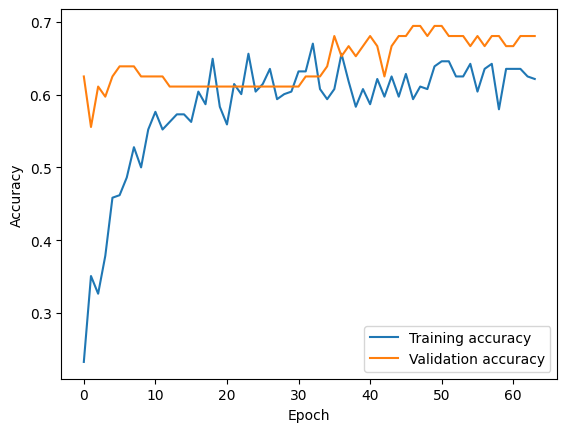

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


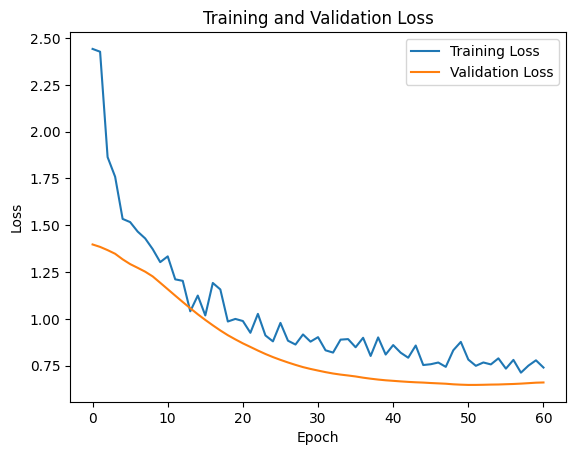

In [ ]:
# prompt: make a train and val loss plot for my model

import matplotlib.pyplot as plt

# Extract the training and validation loss from the history dictionary
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create the plot
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Add legend and show the plot
plt.legend()
plt.show()


In [ ]:
# Make predictions on the validation set
predictions = model.predict(X_val)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print the predicted labels
print("Predicted labels:", predicted_labels)


3/3 [==============================] - 1s 74ms/step
Predicted labels: [0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 2 2 2 0 1 2 0 1 1 2 1 0 0 0 0 0 1 0 2 2 1 1
 0 0 2 2 0 0 0 1 1 1 1 0 2 2 1 2 0 2 0 1 0 0 1 1 2 1 0 2 1 0 2 2 1 1 2 2 0]


In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_val, predicted_labels)
print(conf_matrix)

[[12  1  8]
 [10 23  3]
 [ 9  0  8]]


3/3 [==============================] - 0s 66ms/step


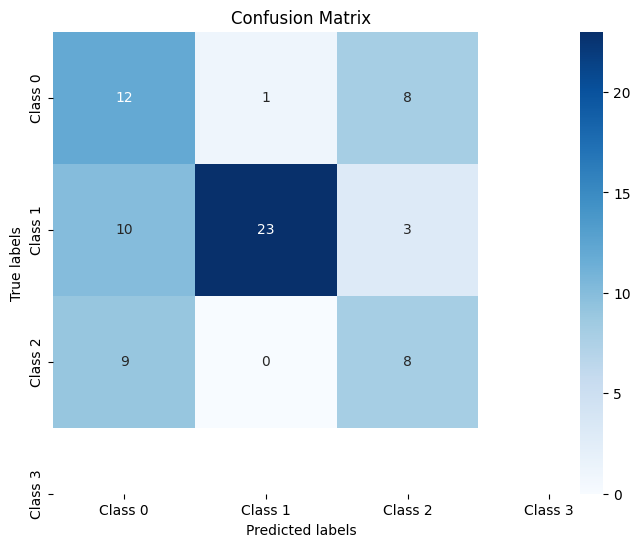

F1 Score: 0.606052206052206


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

# Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)

# Compute F1 score
f1 = f1_score(y_val, y_pred_classes, average='weighted')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("F1 Score:", f1)

In [ ]:
# prompt: save the model
model.save('my_model_4_30.h5')


  saving_api.save_model(



In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, Dense

# Define the input shape
input_shape = (1000, 1000)  # Example input shape

# Define the number of classes
num_classes = 4  # Example number of classes

# Initialize the Sequential model
model2 = Sequential()

# Add Bidirectional LSTM layer
model2.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=input_shape))

# Add GlobalMaxPooling1D layer
model2.add(GlobalMaxPooling1D())

# Add Dense layers for classification
model2.add(Dense(64, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))

# Compile the model
model2.compile(optimizer=SGD(learning_rate=0.0001,momentum=.9, weight_decay= wd), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print(model2.summary())


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirecti  (None, 1000, 256)         1156096   
 onal)                                                           
                                                                 
 global_max_pooling1d_5 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_12 (Dense)            (None, 64)                16448     
                                                                 
 dense_13 (Dense)            (None, 4)                 260       
                                                                 
Total params: 1172804 (4.47 MB)
Trainable params: 1172804 (4.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model2.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=64, callbacks=[early_stopping])


NameError: name 'model2' is not defined

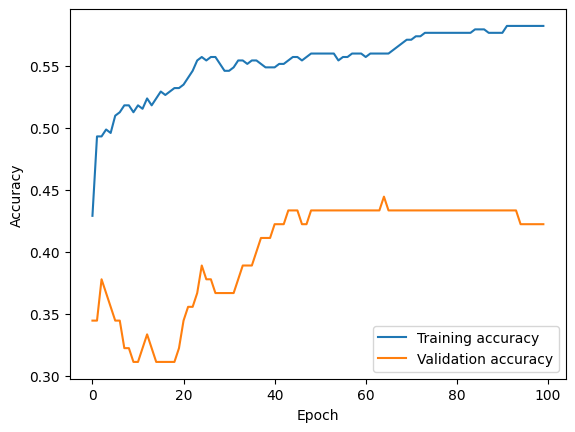

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

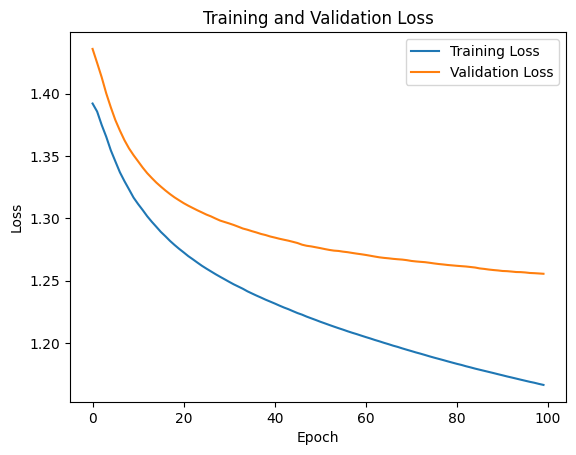

In [ ]:
# Extract the training and validation loss from the history dictionary
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create the plot
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Add legend and show the plot
plt.legend()
plt.show()


## Unlabeled Data Processing

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("my_model_4_30.h5")

## Test Data Predictions

In [ ]:
import glob
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_test_data(test_folder, num_sequences=1000, max_length=1000, max_files=200, specific_files=None):
    # Fetch all CSV files from the input folder
    all_files = glob.glob(os.path.join(test_folder, "*.csv"))

    # If specific files are provided, filter to include only those files
    if specific_files:
        all_files = [f for f in all_files if any(sf in f for sf in specific_files)]

    # Limit the number of files processed based on max_files
    selected_files = all_files[:max_files]

    test_data = []
    for file in selected_files:
        df = pd.read_csv(file, header=None)
        # Ensure the data has the correct number of sequences
        if len(df) > num_sequences:
            df = df.iloc[:num_sequences]  # Truncate if more than 1024 sequences
        elif len(df) < num_sequences:
            # Pad with zeros if fewer than 1024 sequences
            padding = pd.DataFrame(0, index=np.arange(num_sequences - len(df)), columns=df.columns)
            df = pd.concat([df, padding], ignore_index=True)

        # Pad or truncate each sequence to have a length of 1000
        padded_data = pad_sequences(df.values, maxlen=max_length, dtype='float32', padding='post', truncating='post')
        test_data.append(padded_data)

    return test_data, selected_files

In [ ]:
def predict(model, test_data):
    predictions = []
    for data in test_data:
        # Reshape data to ensure it matches the expected input shape of the model
        # Model expects (None, 1024, 1000), where None is the batch size
        if data.shape[0] == 1000 and data.shape[1] == 1000:
            prediction = model.predict(np.expand_dims(data, axis=0))  # Add the batch dimension
            predictions.append(prediction)
        else:
            print("Data shape mismatch, skipping prediction.")
    return predictions

In [ ]:
# Load test data
test_folder = "/content/drive/MyDrive/Capstone/Processed/Normalized"
test_data, test_files = load_test_data(test_folder)

# Predict
predictions = predict(model, test_data)

# Optionally, print or save the predictions
for file, prediction in zip(test_files, predictions):
    filename = os.path.basename(file)
    print(f"File: {filename}, Prediction: {prediction}")


1/1 [==============================] - 0s 39ms/step
File: 138 T1 part 3 child audio_segment_0.csv, Prediction: [[4.1915695e-03 3.0806274e-03 9.9236405e-01 3.6375716e-04]]
File: 138 T1 part 3 child audio_segment_1.csv, Prediction: [[4.7761444e-03 6.5700430e-03 9.8817796e-01 4.7593846e-04]]
File: 138 T1 part 3 child audio_segment_2.csv, Prediction: [[1.2031954e-02 5.8909063e-03 9.8175037e-01 3.2676916e-04]]
File: 138 T1 part 3 child audio_segment_3.csv, Prediction: [[1.3195041e-02 5.0786943e-03 9.8128319e-01 4.4308187e-04]]
File: 138 T1 part 3 child audio_segment_4.csv, Prediction: [[6.2104426e-03 3.7816118e-03 9.8958731e-01 4.2062689e-04]]
File: 138 T1 part 3 child audio_segment_5.csv, Prediction: [[1.0054219e-02 4.3638642e-03 9.8507673e-01 5.0516916e-04]]
File: 138 T1 part 3 child audio_segment_7.csv, Prediction: [[0.01836469 0.01598823 0.9636471  0.002     ]]
File: 138 T1 part 3 child audio_segment_6.csv, Prediction: [[0.00988867 0.0126277  0.97612745 0.00135623]]
File: 138 T1 part 3 